In [1]:
import torch
import matplotlib.pyplot as plt

In [121]:
class GPIS:
    def __init__(self, sigma, bias):
        self.sigma = sigma
        self.bias = bias

    def exponentiated_quadratic(self, xa, xb):
        # L2 distance (Squared Euclidian)
        sq_norm = -0.5 * torch.cdist(xa,xb)**2 / self.sigma**2
        return torch.exp(sq_norm)
    
    def fit(self, X1, y1, noise=0.0):
        self.X1 = X1
        self.y1 = y1 - self.bias
        self.E11 = self.exponentiated_quadratic(X1, X1) + ((noise ** 2) * torch.eye(len(X1)))

    def pred(self, X2, use_grad=False):
        with torch.enable_grad():
            X2 = X2.requires_grad_(use_grad)
            E12 = self.exponentiated_quadratic(self.X1, X2)
            # Solve
            solved = torch.linalg.solve(self.E11, E12).T
            # Compute posterior mean
            print(solved.shape)
            mu_2 = solved @ self.y1
            # Compute the posterior covariance
            E22 = self.exponentiated_quadratic(X2, X2)
            E2 = E22 - (solved @ E12)
            if use_grad:
                mu_2.sum().backward()
                normal = X2.grad
                normal = normal / torch.norm(normal, dim=1, keepdim=True)
            else:
                normal = None
            X2.requires_grad_(False)
            mu_2 = mu_2.detach()
        return mu_2 + self.bias,  torch.sqrt(torch.diag(E2)), -normal

In [122]:
def dummy(x):
    with torch.enable_grad():
        x.requires_grad_(True)
        y = torch.norm(x, dim=-1)
        y.sum().backward()
        normal = x.grad
        normal = normal / torch.norm(normal, dim=1, keepdim=True)
        x.requires_grad_(False)
    return y, normal

In [123]:
x = torch.tensor([[-0.2,0], [-0.2,0.1], [-0.2,-0.1], 
                  [0.2, 0], [0.2, 0.1], [0.2, -0.1],
                  [0,-0.2], [0.1,-0.2], [-0.1,-0.2],
                  [0, 0.2], [0.1, 0.2], [-0.1, 0.2]])
y = torch.tensor([0.0, 0.0, 0.0, 0.0] * 3).reshape(-1,1)

# Plot the GP mean and covariance
model = GPIS(0.2, 1.0)
model.fit(x, y, noise=0.01)
x_test = torch.stack(torch.meshgrid(torch.linspace(-0.5, 0.5, 20), torch.linspace(-0.5, 0.5, 20)),dim=2)

y_test = torch.zeros(20,20, dtype=torch.float32)
y_normal = torch.zeros(20,20,2, dtype=torch.float32)

for i in range(20):
    for j in range(20):
        y_pred, _,normal = model.pred(x_test[i,j].view(1,-1), use_grad=True)
        y_test[i,j] = y_pred.flatten()
        y_normal[i,j,:] = normal.squeeze()

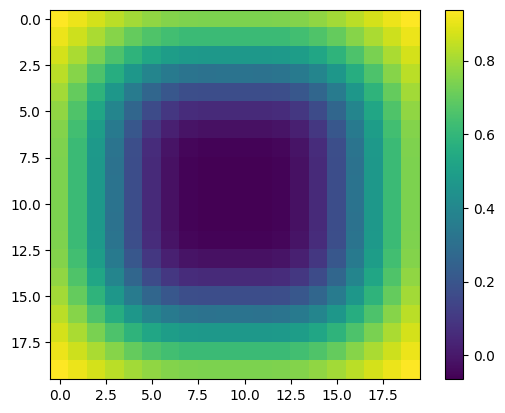

In [124]:
plt.imshow(y_test.numpy())
plt.colorbar()

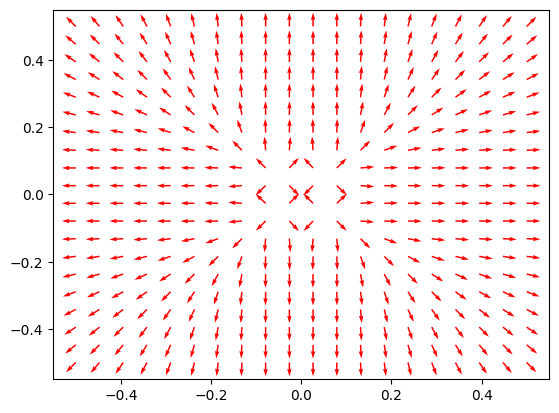

In [125]:
import numpy as np
mesh_x, mesh_y = np.meshgrid(np.linspace(-0.5,0.5,20), np.linspace(-0.5,0.5,20))
plt.quiver(mesh_x, mesh_y, y_normal[:,:,1], y_normal[:,:,0], color='red')

In [95]:
x_test.shape

torch.Size([20, 20, 2])

In [104]:
dummy(torch.tensor([[0.2, 0.0]]))

(tensor([0.2000], grad_fn=<CopyBackwards>), tensor([[1., 0.]]))